In [1]:
import os
import time
import pandas as pd
import numpy as np
from random import sample
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from Bio import SeqIO
from multiprocessing import Process

import matplotlib.pyplot as plt

# device

In [2]:
dev = 'cuda'
dev2 = 'cuda'

# prep

In [3]:
clade_info = pd.read_csv('clade_info_2.csv',
                         index_col = 0,
                         header = None)
# clade_info

clade = {}

for x in set(clade_info.iloc[:, 0]):
    clade[x] = []

for x in list(clade_info.index):
    clade[clade_info.loc[x, 1]].append(x)

In [4]:
for x in clade.keys():
    print(len(clade[x]))

190
190
188
190
183
186


In [5]:
train_set = []
test_set = []

total_each = 135
for_train = 70

for x in clade.keys():
    to = sample(clade[x], total_each)# 每个类取 个
    train_set.extend(to[0: for_train])# 给训练集 个
    test_set.extend(to[for_train: ])# 给测试集 个
    
print(len(train_set))
print(len(test_set))

420
390


In [6]:
softmax = {'A': [1,0,0,0,0,0], 
           'B1': [0,1,0,0,0,0], 
           'B2': [0,0,1,0,0,0],
           'D': [0,0,0,1,0,0],
           'E': [0,0,0,0,1,0],
           'N9': [0,0,0,0,0,1],}

bo_d = {}

for x in softmax.keys():
    if x == 'B2':
        bo_d[x] = [1]
    else:
        bo_d[x] = [0]

# load

In [7]:
to_stack_x = []
to_stack_y = []

count = 0

for x in train_set:
    path = 'np/'
    
    to_stack_x.append(torch.from_numpy(np.load(path 
                                               + x 
                                               + '.npy')
                                      ).type(torch.FloatTensor).to(device = dev)
                     )
    to_stack_y.append(softmax[clade_info.loc[x, 1]
                              ]
                     )

#     to_stack_y.append(bo_d[clade_info.loc[x, 1]
#                               ]
#                      )
                                               
    
    print(count)
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
to_stack_x_test = []
to_stack_y_test = []

count = 0

for x in test_set:
    path = 'np/'
    
    to_stack_x_test.append(torch.from_numpy(np.load(path
                                                    + x 
                                                    + '.npy')
                                      ).type(torch.FloatTensor).to(device = dev)
                     )
                                               
    to_stack_y_test.append(softmax[clade_info.loc[x, 1]
                                  ]
                     )

#     to_stack_y_test.append(bo_d[clade_info.loc[x, 1]
#                               ]
#                      )
    print(count)
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

path = '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/np/'

t = torch.from_numpy(np.load(path + '11128.npy')
                    ).type(torch.FloatTensor).to(device = dev)

len(t[0])

In [9]:
train_x = torch.stack((to_stack_x))
test_x = torch.stack((to_stack_x_test))

In [10]:
del to_stack_x
del to_stack_x_test

In [11]:
train_x = train_x.reshape(len(train_set), 1, 4, 594444)
test_x = test_x.reshape(len(test_set), 1, 4, 594444)

In [12]:
train_y = torch.FloatTensor(to_stack_y).to(device = dev)
test_y = torch.FloatTensor(to_stack_y_test).to(device = dev)

In [13]:
del to_stack_y
del to_stack_y_test

# model

In [14]:
# ```Python
class the_model(nn.Module):

    def __init__(self):
        super(the_model, self).__init__()
        
#         self.dropout = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = (4, 46),
                               stride = 9
                              ).to(torch.device(dev))
        
        self.mp1 = nn.MaxPool2d(kernel_size = (1, 31), 
                                stride = 5
                               ).to(torch.device(dev)
                                   )
        
        
        self.conv2 = nn.Conv2d(in_channels = 6,
                               out_channels = 1,
                               kernel_size = (1, 6),
#                                stride = 1
                              ).to(torch.device(dev))
        
        self.mp2 = nn.MaxPool2d(kernel_size = (1, 10),
                    stride = 2).to(torch.device(dev))
        
        
        self.conv3 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
                                   
        self.mp3 = nn.MaxPool2d(kernel_size = (1, 20),
                                stride = 5).to(torch.device(dev)
                                              )
                                   
        self.conv4 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
        self.mp4 = nn.MaxPool2d(kernel_size = (1, 30),
                                stride = 10).to(torch.device(dev)
                                               )
        
        self.fc1 = nn.Linear(129, 
                             6
                            ).to(torch.device(dev)
                                )
        
#         self.fc2 = nn.Linear(in_features = 1000, 
#                              out_features = 6
#                             ).to(torch.device(dev)
#                                 )
        
    def forward(self, x):
        
        x = self.conv1(x)
#         x = self.dropout(x)
        x = self.mp1(x)
        
        x = self.conv2(x)
#         x = self.dropout(x)
        x = self.mp2(x)
        
        x = self.conv3(x)
#         x = self.dropout(x)
        x = self.mp3(x)
                                   
        x = self.conv4(x)
#         x = self.dropout(x)
        x = self.mp4(x)
        
        x = torch.flatten(x, 1)
#         x = self.dropout(x)
        
        x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
        
#         x = self.bo(x)
        
        return x
# ```

In [15]:
net = the_model()

In [16]:
loss_function = nn.CrossEntropyLoss().to(torch.device(dev))
# loss_function = nn.MSELoss().to(torch.device(dev))
# loss_function = nn.BCELoss().to(torch.device(dev))
optimizer = torch.optim.Adam(net.parameters(), 
                             lr = 5e-3,
                             weight_decay = 0 # 1e-4
                            )

In [17]:
m1 = nn.Sigmoid()
m2 = nn.Softmax(dim = 1)

In [18]:
print(len(train_set))
print(len(test_set))

420
390


0
Sun Jan 29 13:45:16 2023
train loss: 1.8037357330322266
test loss: 1.8036177158355713
predict right count in train: tensor(70, device='cuda:0')
predict right count in test: tensor(65, device='cuda:0')


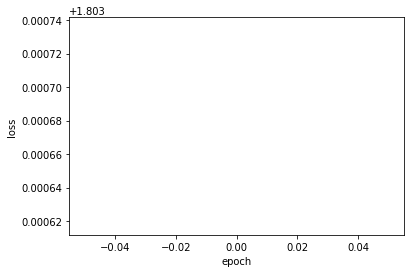

1
Sun Jan 29 13:45:19 2023
train loss: 1.7932053804397583
test loss: 1.7932835817337036
predict right count in train: tensor(70, device='cuda:0')
predict right count in test: tensor(65, device='cuda:0')


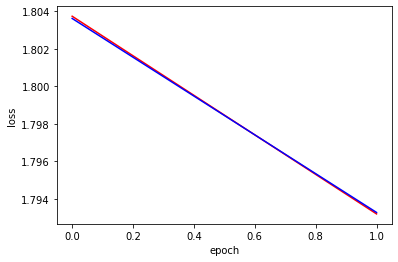

2
Sun Jan 29 13:45:19 2023
train loss: 1.7889881134033203
test loss: 1.7890632152557373
predict right count in train: tensor(70, device='cuda:0')
predict right count in test: tensor(65, device='cuda:0')


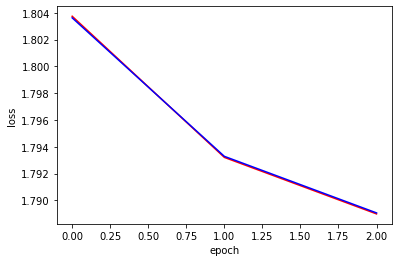

3
Sun Jan 29 13:45:19 2023
train loss: 1.7880170345306396
test loss: 1.7881135940551758
predict right count in train: tensor(70, device='cuda:0')
predict right count in test: tensor(65, device='cuda:0')


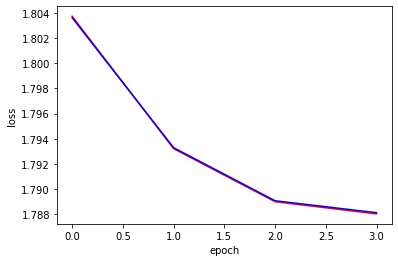

4
Sun Jan 29 13:45:20 2023
train loss: 1.7871379852294922
test loss: 1.7873247861862183
predict right count in train: tensor(70, device='cuda:0')
predict right count in test: tensor(65, device='cuda:0')


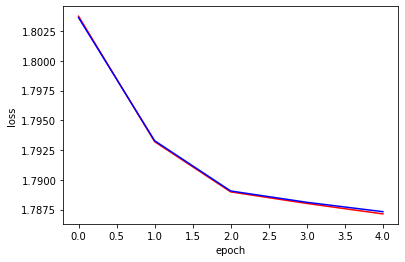

5
Sun Jan 29 13:45:20 2023
train loss: 1.7854782342910767
test loss: 1.7857149839401245
predict right count in train: tensor(139, device='cuda:0')
predict right count in test: tensor(121, device='cuda:0')


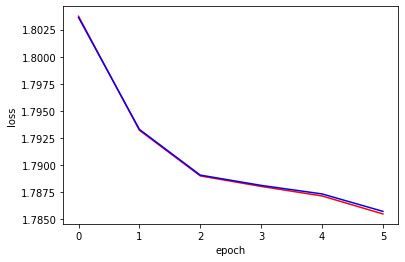

6
Sun Jan 29 13:45:20 2023
train loss: 1.783037543296814
test loss: 1.7833051681518555
predict right count in train: tensor(120, device='cuda:0')
predict right count in test: tensor(115, device='cuda:0')


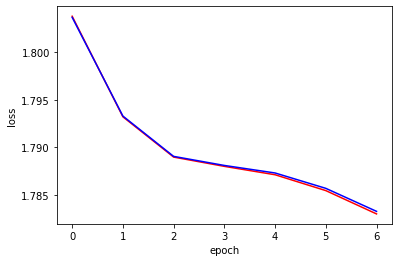

7
Sun Jan 29 13:45:21 2023
train loss: 1.7798113822937012
test loss: 1.7800712585449219
predict right count in train: tensor(105, device='cuda:0')
predict right count in test: tensor(99, device='cuda:0')


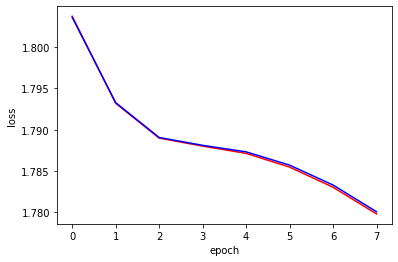

8
Sun Jan 29 13:45:21 2023
train loss: 1.776240587234497
test loss: 1.7765679359436035
predict right count in train: tensor(107, device='cuda:0')
predict right count in test: tensor(104, device='cuda:0')


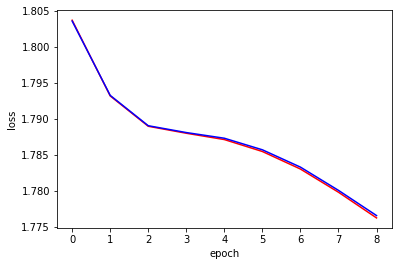

9
Sun Jan 29 13:45:21 2023
train loss: 1.7723873853683472
test loss: 1.7726914882659912
predict right count in train: tensor(204, device='cuda:0')
predict right count in test: tensor(203, device='cuda:0')


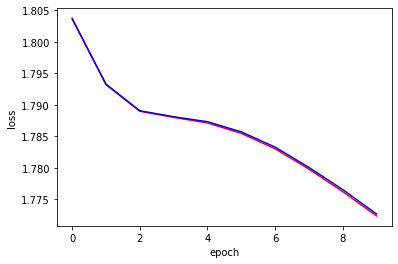

10
Sun Jan 29 13:45:21 2023
train loss: 1.768388032913208
test loss: 1.768774151802063
predict right count in train: tensor(290, device='cuda:0')
predict right count in test: tensor(277, device='cuda:0')


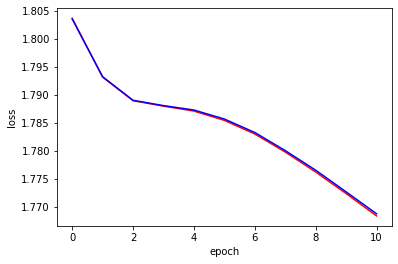

11
Sun Jan 29 13:45:22 2023
train loss: 1.7631531953811646
test loss: 1.7636502981185913
predict right count in train: tensor(231, device='cuda:0')
predict right count in test: tensor(211, device='cuda:0')


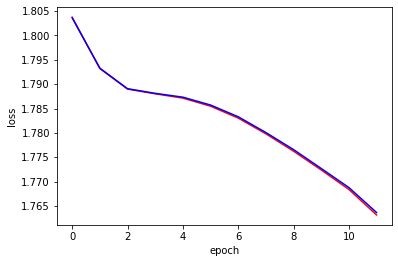

12
Sun Jan 29 13:45:22 2023
train loss: 1.7574163675308228
test loss: 1.7580279111862183
predict right count in train: tensor(302, device='cuda:0')
predict right count in test: tensor(274, device='cuda:0')


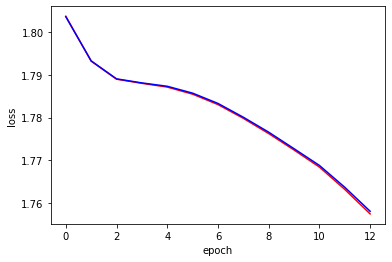

13
Sun Jan 29 13:45:22 2023
train loss: 1.7510521411895752
test loss: 1.7519128322601318
predict right count in train: tensor(306, device='cuda:0')
predict right count in test: tensor(282, device='cuda:0')


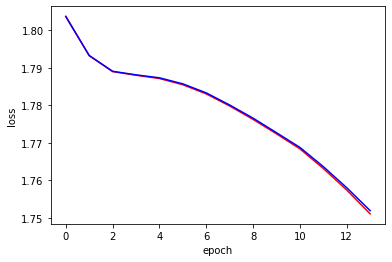

14
Sun Jan 29 13:45:22 2023
train loss: 1.742913007736206
test loss: 1.7440364360809326
predict right count in train: tensor(313, device='cuda:0')
predict right count in test: tensor(289, device='cuda:0')


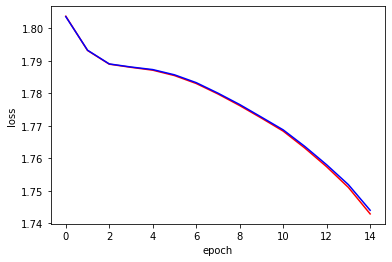

15
Sun Jan 29 13:45:23 2023
train loss: 1.732967734336853
test loss: 1.734403371810913
predict right count in train: tensor(327, device='cuda:0')
predict right count in test: tensor(306, device='cuda:0')


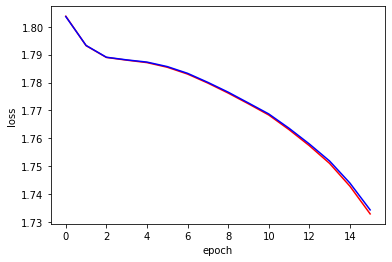

16
Sun Jan 29 13:45:23 2023
train loss: 1.721376895904541
test loss: 1.7231818437576294
predict right count in train: tensor(351, device='cuda:0')
predict right count in test: tensor(320, device='cuda:0')


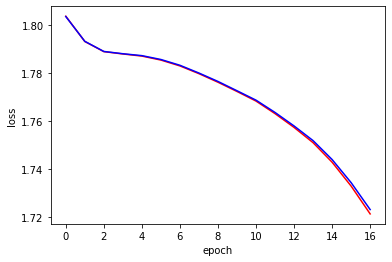

17
Sun Jan 29 13:45:23 2023
train loss: 1.708306074142456
test loss: 1.710417628288269
predict right count in train: tensor(365, device='cuda:0')
predict right count in test: tensor(337, device='cuda:0')


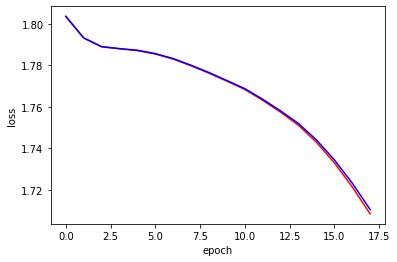

18
Sun Jan 29 13:45:23 2023
train loss: 1.6920934915542603
test loss: 1.6946159601211548
predict right count in train: tensor(367, device='cuda:0')
predict right count in test: tensor(339, device='cuda:0')


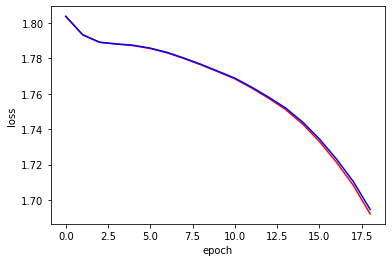

19
Sun Jan 29 13:45:23 2023
train loss: 1.6740635633468628
test loss: 1.6771754026412964
predict right count in train: tensor(382, device='cuda:0')
predict right count in test: tensor(350, device='cuda:0')


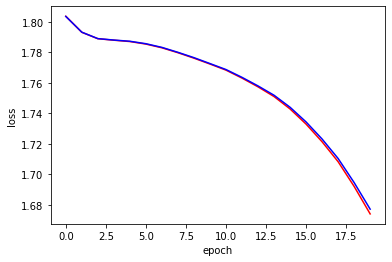

20
Sun Jan 29 13:45:24 2023
train loss: 1.6519604921340942
test loss: 1.65562105178833
predict right count in train: tensor(395, device='cuda:0')
predict right count in test: tensor(360, device='cuda:0')


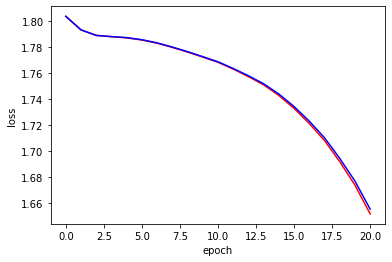

21
Sun Jan 29 13:45:24 2023
train loss: 1.628313422203064
test loss: 1.632133960723877
predict right count in train: tensor(403, device='cuda:0')
predict right count in test: tensor(370, device='cuda:0')


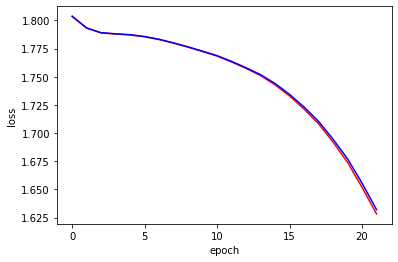

22
Sun Jan 29 13:45:24 2023
train loss: 1.597011685371399
test loss: 1.6016082763671875
predict right count in train: tensor(409, device='cuda:0')
predict right count in test: tensor(374, device='cuda:0')


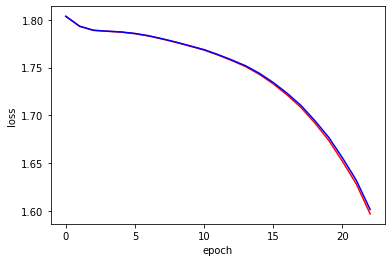

23
Sun Jan 29 13:45:24 2023
train loss: 1.5638749599456787
test loss: 1.5692098140716553
predict right count in train: tensor(410, device='cuda:0')
predict right count in test: tensor(376, device='cuda:0')


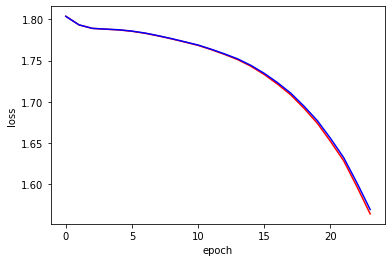

24
Sun Jan 29 13:45:24 2023
train loss: 1.5260990858078003
test loss: 1.5322257280349731
predict right count in train: tensor(410, device='cuda:0')
predict right count in test: tensor(376, device='cuda:0')


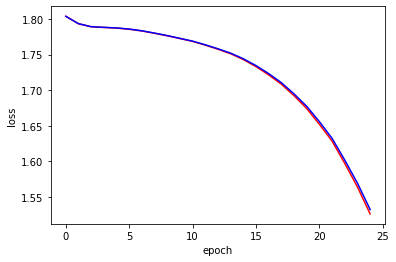

25
Sun Jan 29 13:45:25 2023
train loss: 1.4832816123962402
test loss: 1.4906976222991943
predict right count in train: tensor(410, device='cuda:0')
predict right count in test: tensor(376, device='cuda:0')


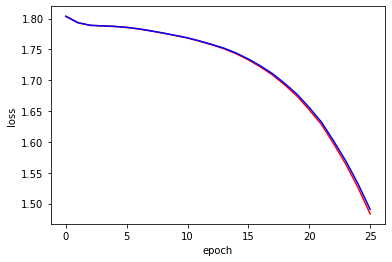

26
Sun Jan 29 13:45:25 2023
train loss: 1.435041069984436
test loss: 1.443158745765686
predict right count in train: tensor(411, device='cuda:0')
predict right count in test: tensor(377, device='cuda:0')


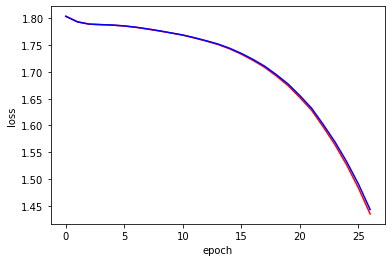

27
Sun Jan 29 13:45:25 2023
train loss: 1.38005793094635
test loss: 1.389373540878296
predict right count in train: tensor(410, device='cuda:0')
predict right count in test: tensor(377, device='cuda:0')


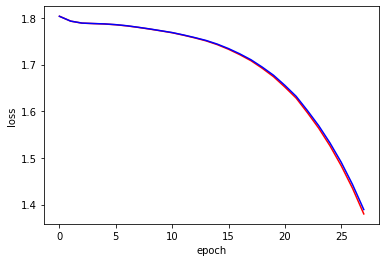

28
Sun Jan 29 13:45:25 2023
train loss: 1.3205100297927856
test loss: 1.331022024154663
predict right count in train: tensor(410, device='cuda:0')
predict right count in test: tensor(376, device='cuda:0')


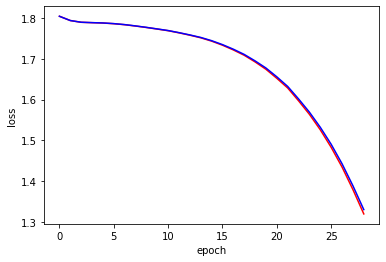

29
Sun Jan 29 13:45:26 2023
train loss: 1.2558072805404663
test loss: 1.2676459550857544
predict right count in train: tensor(410, device='cuda:0')
predict right count in test: tensor(378, device='cuda:0')


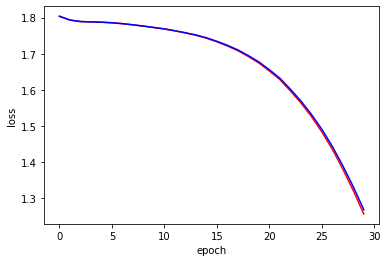

30
Sun Jan 29 13:45:26 2023
train loss: 1.1801577806472778
test loss: 1.1947596073150635
predict right count in train: tensor(411, device='cuda:0')
predict right count in test: tensor(379, device='cuda:0')


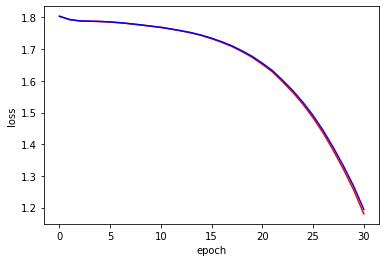

31
Sun Jan 29 13:45:26 2023
train loss: 1.0990005731582642
test loss: 1.1159164905548096
predict right count in train: tensor(416, device='cuda:0')
predict right count in test: tensor(379, device='cuda:0')


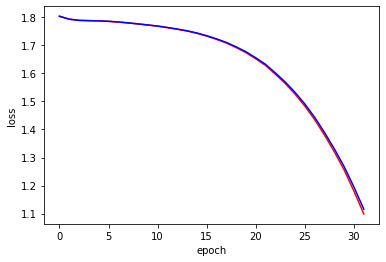

32
Sun Jan 29 13:45:26 2023
train loss: 1.0144139528274536
test loss: 1.0342705249786377
predict right count in train: tensor(415, device='cuda:0')
predict right count in test: tensor(379, device='cuda:0')


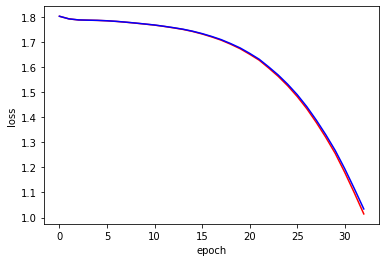

33
Sun Jan 29 13:45:26 2023
train loss: 0.9229721426963806
test loss: 0.9445980191230774
predict right count in train: tensor(414, device='cuda:0')
predict right count in test: tensor(379, device='cuda:0')


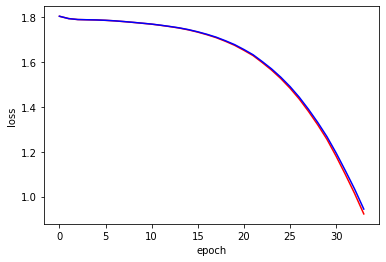

34
Sun Jan 29 13:45:27 2023
train loss: 0.8272519111633301
test loss: 0.8506299257278442
predict right count in train: tensor(415, device='cuda:0')
predict right count in test: tensor(379, device='cuda:0')


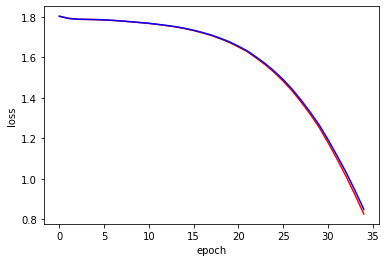

35
Sun Jan 29 13:45:27 2023
train loss: 0.7328049540519714
test loss: 0.757253885269165
predict right count in train: tensor(416, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


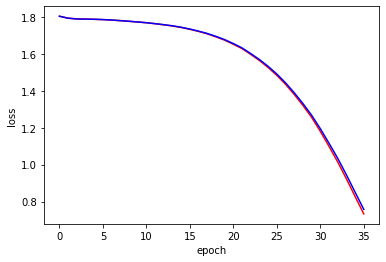

36
Sun Jan 29 13:45:27 2023
train loss: 0.6443796753883362
test loss: 0.6681004166603088
predict right count in train: tensor(417, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


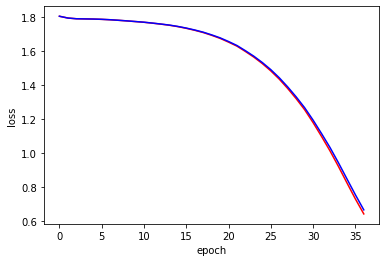

37
Sun Jan 29 13:45:27 2023
train loss: 0.5494814515113831
test loss: 0.5752778649330139
predict right count in train: tensor(417, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


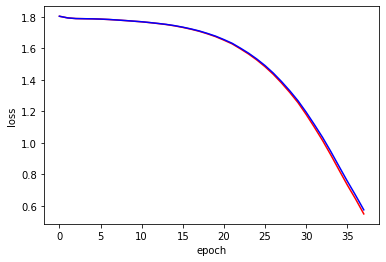

38
Sun Jan 29 13:45:28 2023
train loss: 0.4648687541484833
test loss: 0.4922594726085663
predict right count in train: tensor(416, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


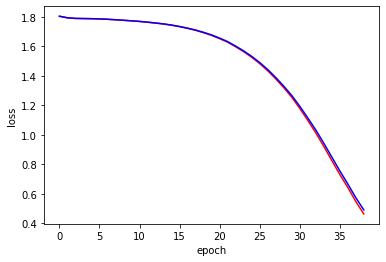

39
Sun Jan 29 13:45:28 2023
train loss: 0.38351714611053467
test loss: 0.4131138324737549
predict right count in train: tensor(416, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


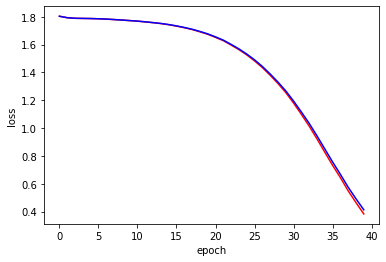

40
Sun Jan 29 13:45:28 2023
train loss: 0.313557893037796
test loss: 0.34378358721733093
predict right count in train: tensor(417, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


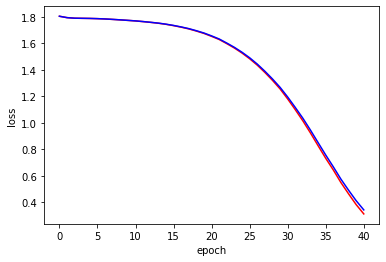

41
Sun Jan 29 13:45:28 2023
train loss: 0.25287872552871704
test loss: 0.28285616636276245
predict right count in train: tensor(418, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


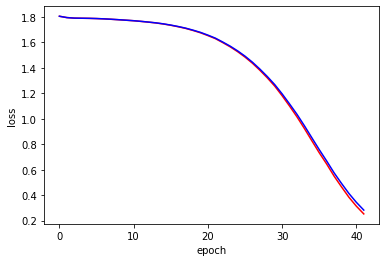

42
Sun Jan 29 13:45:29 2023
train loss: 0.19976727664470673
test loss: 0.2301047444343567
predict right count in train: tensor(419, device='cuda:0')
predict right count in test: tensor(380, device='cuda:0')


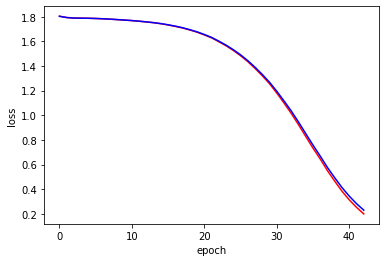

43
Sun Jan 29 13:45:29 2023
train loss: 0.1580411195755005
test loss: 0.18858608603477478
predict right count in train: tensor(419, device='cuda:0')
predict right count in test: tensor(382, device='cuda:0')


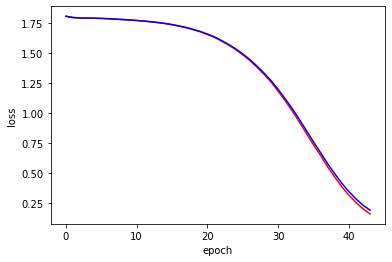

44
Sun Jan 29 13:45:29 2023
train loss: 0.12374746799468994
test loss: 0.15371589362621307
predict right count in train: tensor(419, device='cuda:0')
predict right count in test: tensor(383, device='cuda:0')


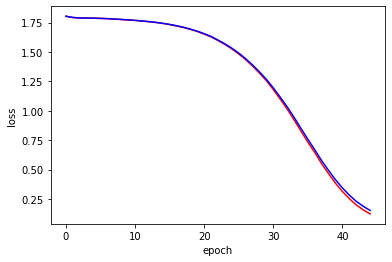

45
Sun Jan 29 13:45:29 2023
train loss: 0.09634412825107574
test loss: 0.12456133961677551
predict right count in train: tensor(419, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


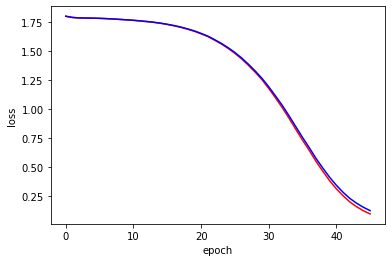

46
Sun Jan 29 13:45:29 2023
train loss: 0.07471133768558502
test loss: 0.10108189284801483
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


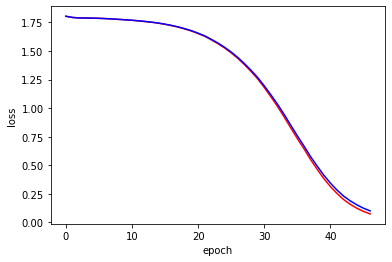

47
Sun Jan 29 13:45:30 2023
train loss: 0.058136072009801865
test loss: 0.08314704149961472
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


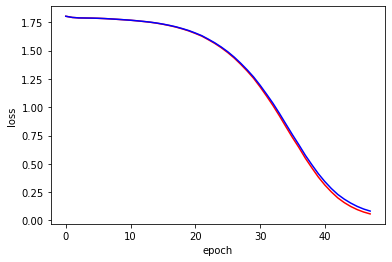

48
Sun Jan 29 13:45:30 2023
train loss: 0.045474790036678314
test loss: 0.06910144537687302
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


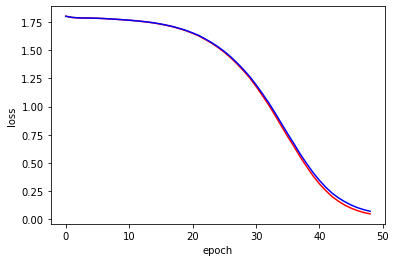

49
Sun Jan 29 13:45:30 2023
train loss: 0.03566599637269974
test loss: 0.05742959305644035
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


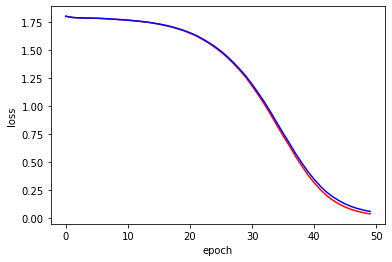

50
Sun Jan 29 13:45:30 2023
train loss: 0.02812557853758335
test loss: 0.04825722798705101
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


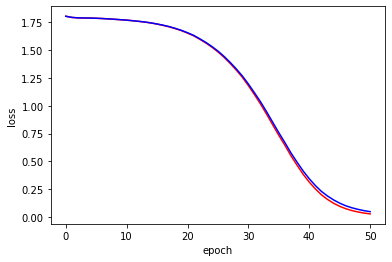

51
Sun Jan 29 13:45:30 2023
train loss: 0.02228967659175396
test loss: 0.04107806831598282
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


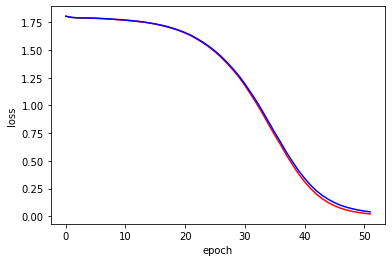

52
Sun Jan 29 13:45:31 2023
train loss: 0.01778235472738743
test loss: 0.03552224859595299
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


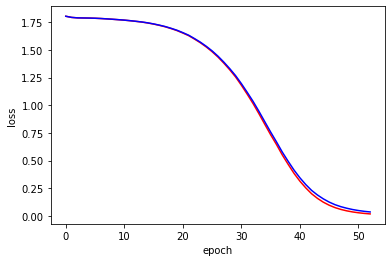

53
Sun Jan 29 13:45:31 2023
train loss: 0.014317719265818596
test loss: 0.031180579215288162
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


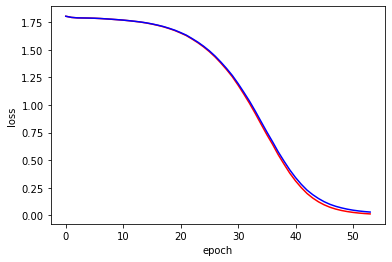

54
Sun Jan 29 13:45:31 2023
train loss: 0.01158380787819624
test loss: 0.027553211897611618
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


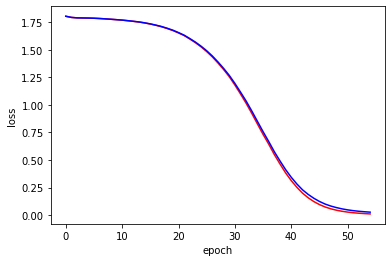

55
Sun Jan 29 13:45:31 2023
train loss: 0.009436470456421375
test loss: 0.024555636569857597
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


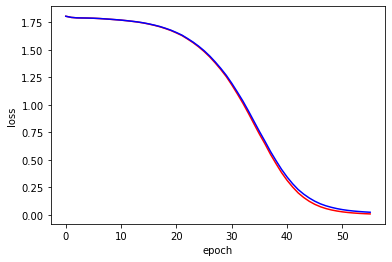

56
Sun Jan 29 13:45:32 2023
train loss: 0.007752606645226479
test loss: 0.022039903327822685
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


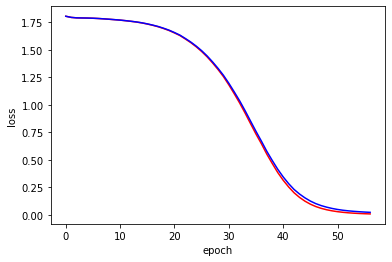

57
Sun Jan 29 13:45:32 2023
train loss: 0.006427296437323093
test loss: 0.019926540553569794
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


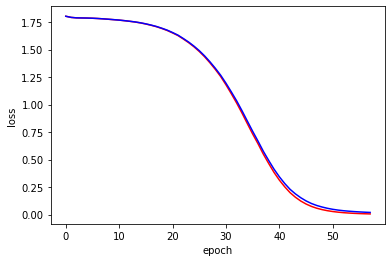

58
Sun Jan 29 13:45:32 2023
train loss: 0.005373138468712568
test loss: 0.018112679943442345
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


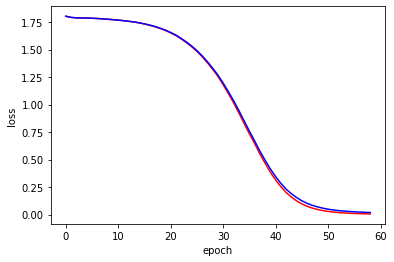

59
Sun Jan 29 13:45:32 2023
train loss: 0.004523617215454578
test loss: 0.016511550173163414
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


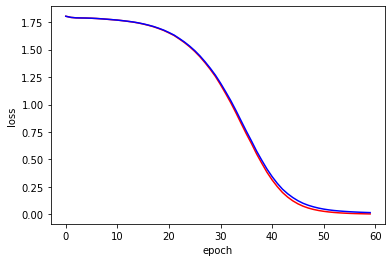

60
Sun Jan 29 13:45:32 2023
train loss: 0.0038383968640118837
test loss: 0.015117134898900986
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


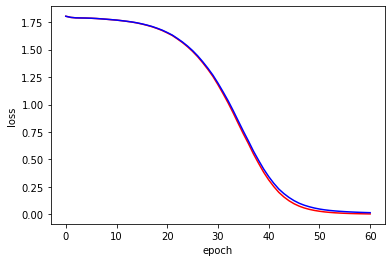

61
Sun Jan 29 13:45:33 2023
train loss: 0.0032906709238886833
test loss: 0.013924334198236465
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


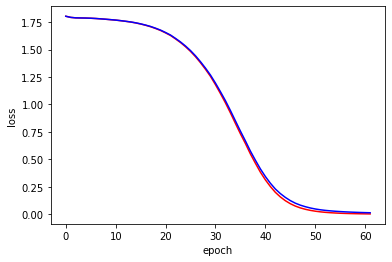

62
Sun Jan 29 13:45:33 2023
train loss: 0.0028524952940642834
test loss: 0.012904803268611431
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


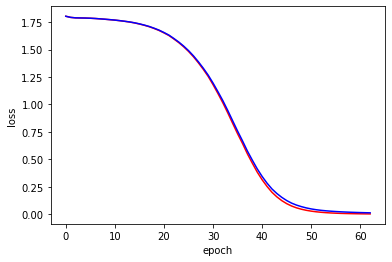

63
Sun Jan 29 13:45:33 2023
train loss: 0.0024977046996355057
test loss: 0.012042732909321785
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


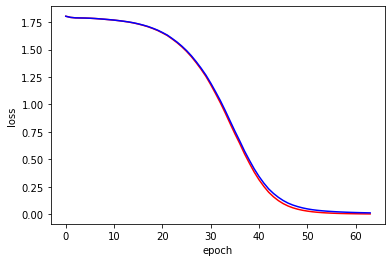

64
Sun Jan 29 13:45:33 2023
train loss: 0.002209137659519911
test loss: 0.011338310316205025
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


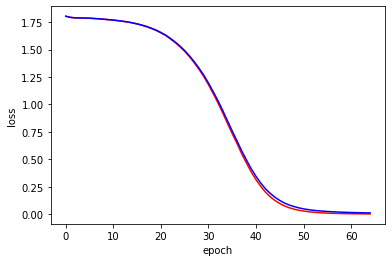

65
Sun Jan 29 13:45:34 2023
train loss: 0.001973044127225876
test loss: 0.010751262307167053
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


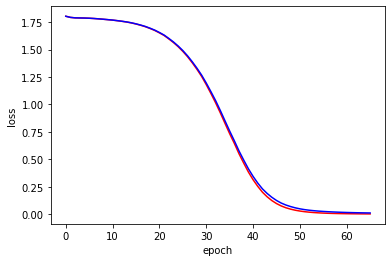

66
Sun Jan 29 13:45:34 2023
train loss: 0.0017769146943464875
test loss: 0.01029349584132433
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


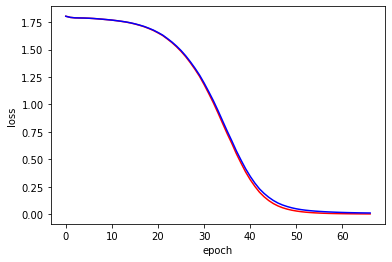

67
Sun Jan 29 13:45:34 2023
train loss: 0.001612030086107552
test loss: 0.00993089098483324
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


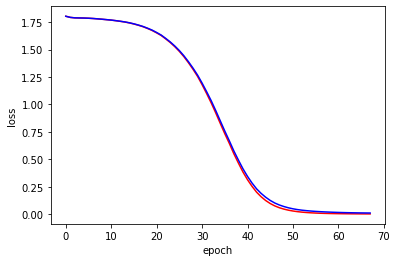

68
Sun Jan 29 13:45:34 2023
train loss: 0.0014733094722032547
test loss: 0.009641787968575954
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


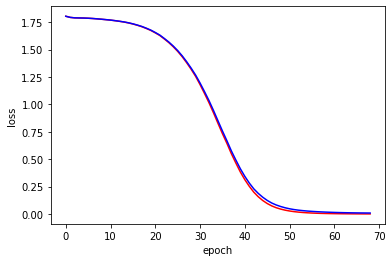

69
Sun Jan 29 13:45:34 2023
train loss: 0.0013544369721785188
test loss: 0.00940721482038498
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


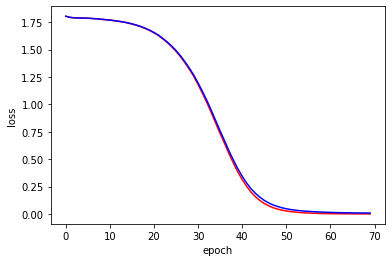

70
Sun Jan 29 13:45:35 2023
train loss: 0.0012512924149632454
test loss: 0.009188326075673103
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


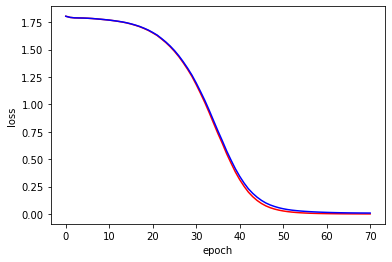

71
Sun Jan 29 13:45:35 2023
train loss: 0.0011616480769589543
test loss: 0.008982392959296703
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


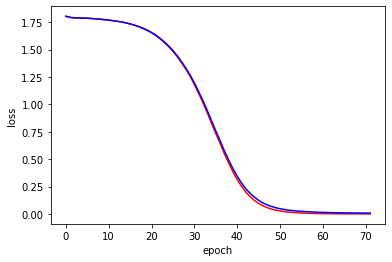

72
Sun Jan 29 13:45:35 2023
train loss: 0.0010832345578819513
test loss: 0.008788510225713253
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


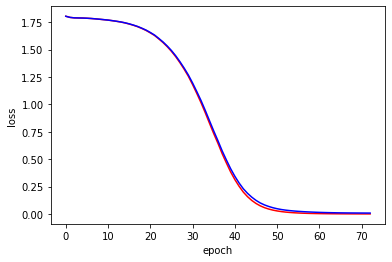

73
Sun Jan 29 13:45:35 2023
train loss: 0.00101409328635782
test loss: 0.008601820096373558
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


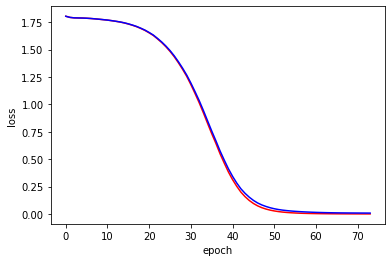

74
Sun Jan 29 13:45:36 2023
train loss: 0.0009537781006656587
test loss: 0.008429300971329212
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


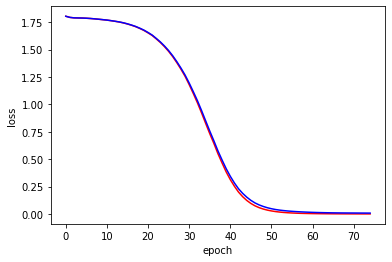

75
Sun Jan 29 13:45:36 2023
train loss: 0.0009001452708616853
test loss: 0.008271904662251472
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


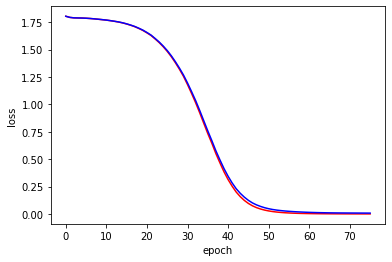

76
Sun Jan 29 13:45:36 2023
train loss: 0.0008525875746272504
test loss: 0.008124496787786484
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


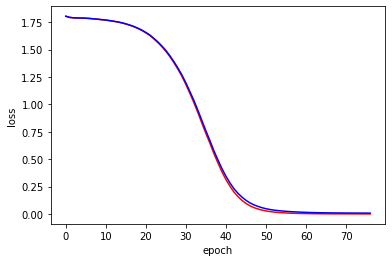

77
Sun Jan 29 13:45:36 2023
train loss: 0.000810332247056067
test loss: 0.007985744625329971
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


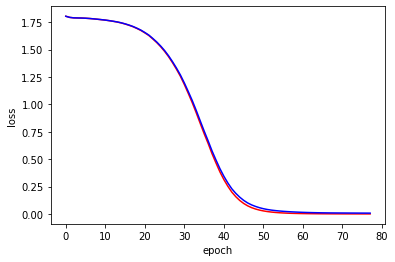

78
Sun Jan 29 13:45:37 2023
train loss: 0.0007727001793682575
test loss: 0.007854609750211239
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


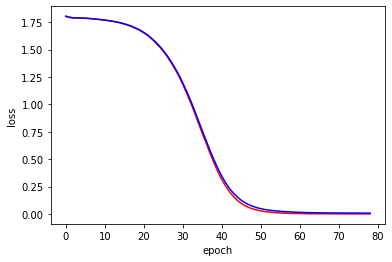

79
Sun Jan 29 13:45:37 2023
train loss: 0.0007390168029814959
test loss: 0.007730158977210522
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


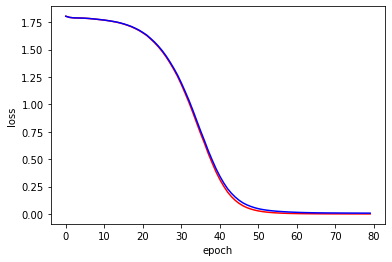

80
Sun Jan 29 13:45:37 2023
train loss: 0.000708924955688417
test loss: 0.007612273097038269
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


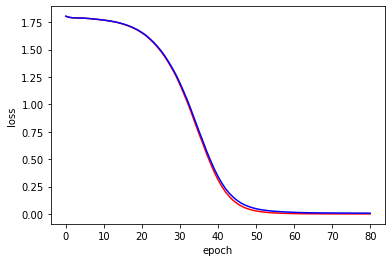

81
Sun Jan 29 13:45:37 2023
train loss: 0.0006819664849899709
test loss: 0.007503231056034565
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


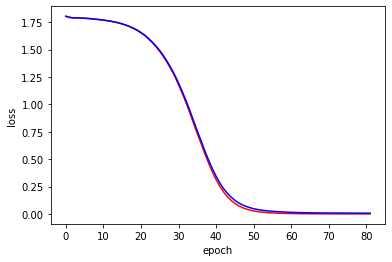

82
Sun Jan 29 13:45:37 2023
train loss: 0.0006578140310011804
test loss: 0.00740272831171751
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


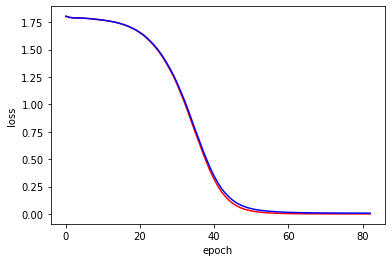

83
Sun Jan 29 13:45:38 2023
train loss: 0.0006360650877468288
test loss: 0.007303991355001926
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


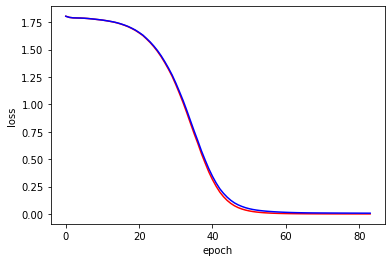

84
Sun Jan 29 13:45:38 2023
train loss: 0.0006162741337902844
test loss: 0.0072142272256314754
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


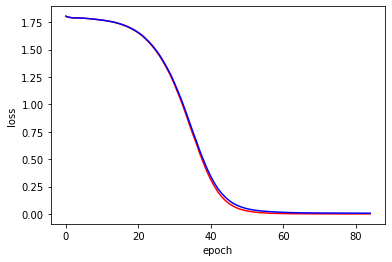

85
Sun Jan 29 13:45:38 2023
train loss: 0.0005983557784929872
test loss: 0.007135848049074411
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


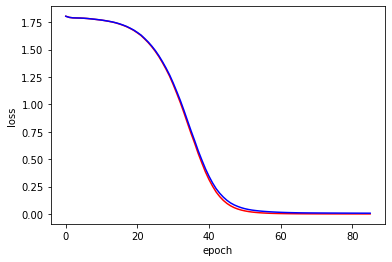

86
Sun Jan 29 13:45:38 2023
train loss: 0.0005819773650728166
test loss: 0.0070661217905581
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


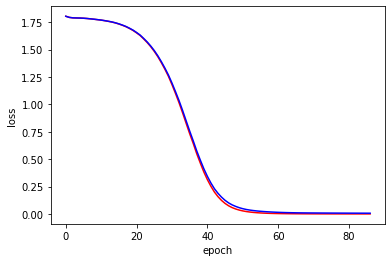

87
Sun Jan 29 13:45:39 2023
train loss: 0.000566950417123735
test loss: 0.007005485240370035
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


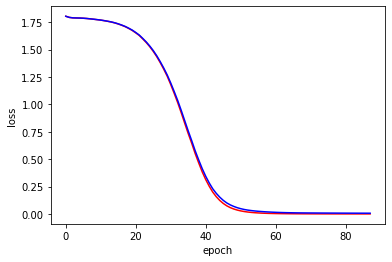

88
Sun Jan 29 13:45:39 2023
train loss: 0.0005530956550501287
test loss: 0.006954567972570658
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


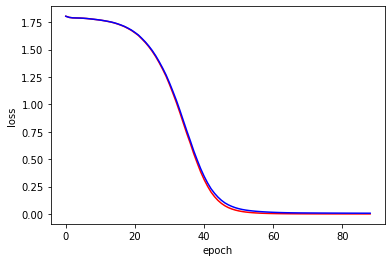

89
Sun Jan 29 13:45:39 2023
train loss: 0.0005402948008850217
test loss: 0.006910649128258228
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


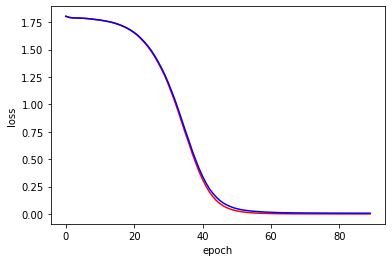

90
Sun Jan 29 13:45:39 2023
train loss: 0.0005284024518914521
test loss: 0.006871079560369253
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


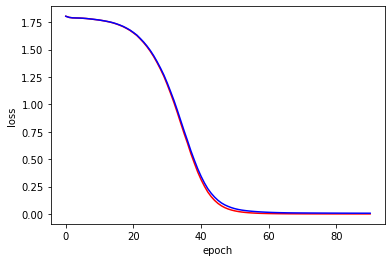

91
Sun Jan 29 13:45:39 2023
train loss: 0.0005172694218344986
test loss: 0.006835428066551685
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


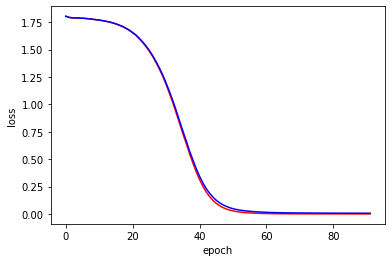

92
Sun Jan 29 13:45:40 2023
train loss: 0.0005068813334219158
test loss: 0.006803139112889767
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


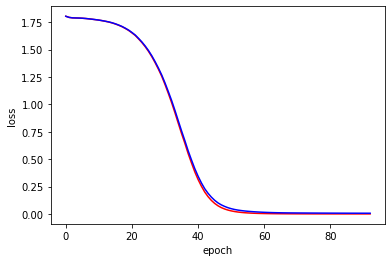

93
Sun Jan 29 13:45:40 2023
train loss: 0.0004971643793396652
test loss: 0.006773470435291529
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


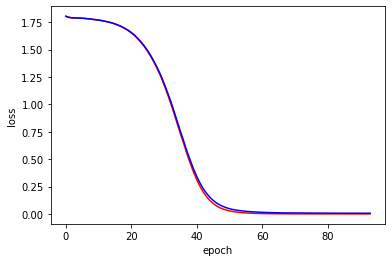

94
Sun Jan 29 13:45:40 2023
train loss: 0.00048810223233886063
test loss: 0.0067476616241037846
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


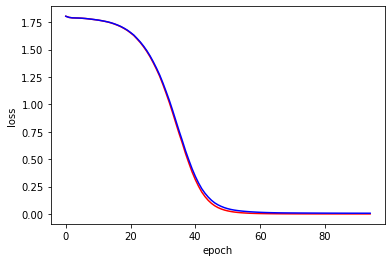

95
Sun Jan 29 13:45:40 2023
train loss: 0.0004796984721906483
test loss: 0.006723507307469845
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


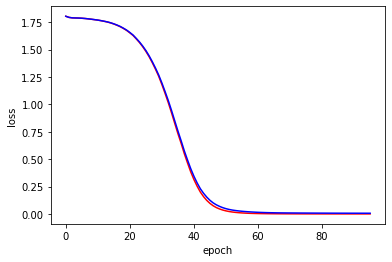

96
Sun Jan 29 13:45:41 2023
train loss: 0.00047185912262648344
test loss: 0.006699880585074425
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


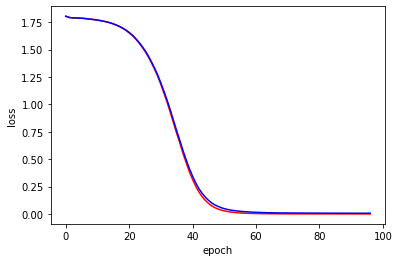

97
Sun Jan 29 13:45:41 2023
train loss: 0.0004644847067538649
test loss: 0.006676164921373129
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


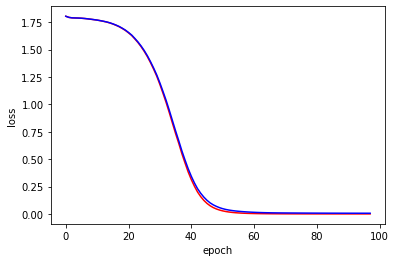

98
Sun Jan 29 13:45:41 2023
train loss: 0.000457563903182745
test loss: 0.006650381255894899
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


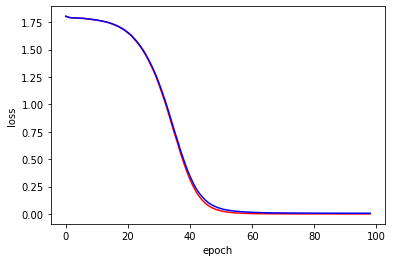

99
Sun Jan 29 13:45:41 2023
train loss: 0.00045101126306690276
test loss: 0.0066217100247740746
predict right count in train: tensor(420, device='cuda:0')
predict right count in test: tensor(390, device='cuda:0')


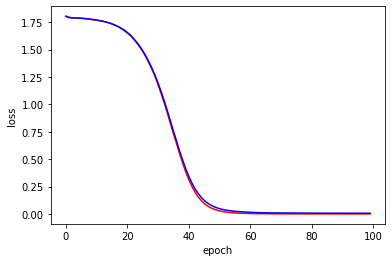

In [19]:
losses = []
losses_test = []

for epoch in range(100):
    
    print(epoch)
    print(time.asctime())
    
    net.eval()
    with torch.no_grad():
        pred_y_test = net(test_x)
        
        loss_test = loss_function(pred_y_test, test_y)
        
        losses_test.append(loss_test.item())
        
        test_right_pred = (m2(m1(pred_y_test
                                )
                             ).argmax(1) == test_y.argmax(1)).sum()
    
    net.train()
    pred_y = net(train_x)
    
    loss = loss_function(pred_y, train_y)

    losses.append(loss.item())
    
    train_right_pred = (m2(m1(pred_y
                                )
                             ).argmax(1) == train_y.argmax(1)).sum()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    plt.plot(losses, 'r')
    plt.plot(losses_test, 'b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.title('Train')

    print('train loss: ' + str(losses[-1]))
    print('test loss: ' + str(losses_test[-1]))
    print('predict right count in train: ' + str(train_right_pred))
    print('predict right count in test: ' + str(test_right_pred))
    
    plt.show()

#     torch.save(net.state_dict(), '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/no_dataloaderr_models/'
#                + str(epoch) 
#                +'_epoch_.pth')

In [20]:
min(losses_test)

0.0066217100247740746

In [21]:
min(losses)

0.00045101126306690276

In [22]:
losses_test.index(min(losses_test
                     )
                 )

99

In [23]:
losses.index(min(losses
                )
            )

99